In [1]:
import sys
import numpy as np
import torch
from torch import nn
from torch.autograd import gradcheck

import matplotlib.pyplot as plt
import pandas as pd

import mnp

In [2]:
#Check DSF eval forward pass
n = 100
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10

n_sub_weights = n * np.prod(layer_sizes)
s_weights = torch.zeros(n_sub_weights, dtype=torch.float64)
s_weights.uniform_(0.0, 1.0)
m_weights = torch.zeros(n, dtype=torch.float64)

A = torch.zeros(n, dtype=torch.float64)
for i in range(n):
    A[i] = 1.0 if np.random.random() < 0.3 else 0.0
Ab = A.numpy() > 0.

print('C++ F Eval: ' + str(mnp.dsf_eval(n, layer_sizes, s_weights.numpy(), m_weights.numpy(), Ab)))
f = mnp.DSF(n, layer_sizes, s_weights)
print('Python F Eval: ' + str(f.eval(A).item()))

#Check Gradient
n = 3
layer_sizes = np.ones(1, dtype=np.int64)
layer_sizes *= 1

#Generate input for DSF
s_input, m_input = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
s_input += 0.1 #Needed for layers - eps to be positive
s_input = torch.tensor(s_input, requires_grad=True)
m_input = torch.zeros(n)
test = gradcheck(mnp.DeepSubmodular.apply, (s_input, m_input, n, layer_sizes), eps=1e-12, atol=.1)
print('Gradient Check: ' + str(test))
#Note:test fails for modular weights but I believe this is a problem with gradcheck


C++ F Eval: 9.713603712799635
Python F Eval: 9.713603712799634
Gradient Check: True


In [3]:
#
# Create a DSF to fit
#

#First generate a submodular set function that we want to fit
#For now, generate a submodular set function
n = 100
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10

sub_weights_gt, mod_weights_gt = mnp.gen_deep_submodular_bernoulli(n, layer_sizes, p=0.2)
FA_gt, yprime_gt = mnp.mnp_deep_contig_w(n, layer_sizes, sub_weights_gt, mod_weights_gt)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))

yprime_gt = torch.tensor(yprime_gt)
A_gt = (yprime_gt <= 0.0).numpy()


Ground Truth F_A*:	-2.032070523215127
Ground Truth |A*|:	41


In [4]:
#
# Initialize the weights to train to fit the above DSF
#

#Initalize weights/variables
s_weights = torch.tensor(np.zeros_like(sub_weights_gt))
s_weights.uniform_(0.0, 1.0)
s_weights.requires_grad=True

#Pick this one to only train the submodular portion
m_weights = torch.tensor(mod_weights_gt, requires_grad=False)

#Pick this one to train both modular and submodular
#m_weights = torch.randn(n, dtype=torch.float64, requires_grad=True)

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(torch.tensor(A_gt, dtype=torch.float64))

losses = []
best_loss = 0
iter_num = 0

iteration 0 loss 67.75608373101275
iteration 50 loss 66.74276187413304
iteration 100 loss 64.3042783904472
iteration 150 loss 63.348303727660905
iteration 200 loss 63.07367836064654
 F_A -5.727825533466709


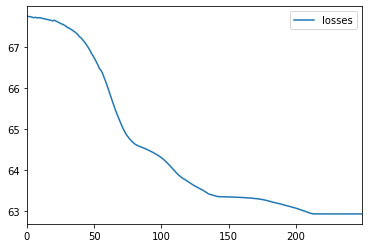

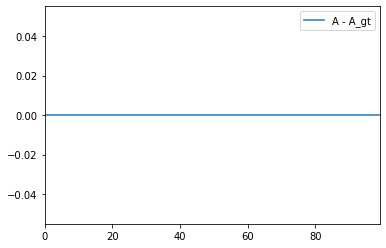

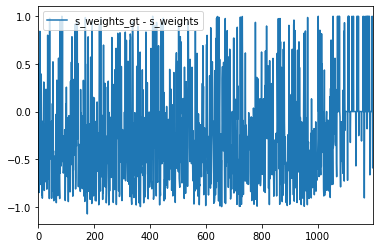

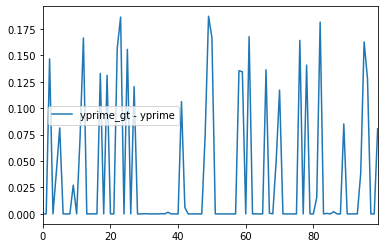

In [5]:
#
# Train for some number of iterations.
# This block can be rerun to continue training.
#

optimizer = torch.optim.SGD([s_weights, m_weights], lr=1e-1)
for i in range(250):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    loss = loss_fn(yprime)
    #loss = torch.mean((yprime - yprime_gt)**2)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0)
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
    iter_num += 1

#print(yprime)
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
#print(A)
#print(A_gt)
df = pd.DataFrame(A-A_gt, columns=('A - A_gt',))
df.plot()
df = pd.DataFrame(sub_weights_gt - s_weights.detach().numpy(), columns = ('s_weights_gt - s_weights',))
df.plot()
df = pd.DataFrame((yprime_gt - yprime).detach().numpy(), columns = ('yprime_gt - yprime',))
df.plot()
plt.show()

Ground Truth F_A*:	-4.669107750273742
Ground Truth |A*|:	77
iteration 0 loss 74.08938377729847
iteration 50 loss 4.12319977208695
iteration 100 loss 2.2962843038963703
iteration 150 loss 1.3559741597570252
iteration 200 loss 1.0069413218385463
iteration 250 loss 0.8023609763860822
 F_A -373.7551712913252


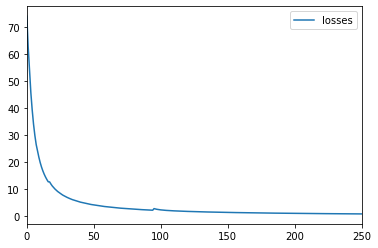

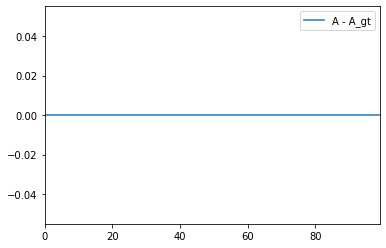

In [23]:
#
# Now create and fit a graph cut submodular function
#

#First create a ground truth submodular function to fit
n = 100
FA_gt, yprime_gt = mnp.watts_strogatz_graph_cut_yprime(n, 16, 0.25)

card = np.count_nonzero(yprime_gt <= 0.0)
print('Ground Truth F_A*:\t' + str(FA_gt))
print('Ground Truth |A*|:\t' + str(card))

yprime_gt = torch.tensor(yprime_gt)

A_gt = torch.ones(n, dtype=torch.float64)
for i in range(n):
    if yprime_gt[i].item() <= 0.0:
        A_gt[i] = 1.0
    else:
        A_gt[i] = 0.0

#Initalize weights/variables
layer_sizes = np.ones(3, dtype=np.int64)
layer_sizes *= 10
n_sub_weights = n * np.prod(layer_sizes)

s_weights = torch.zeros(n_sub_weights, dtype=torch.float64)
s_weights.uniform_(0.0, 1.0)
s_weights.requires_grad=True
m_weights = torch.randn(n, dtype=torch.float64, requires_grad=True)

#Create Model
deep_mnp = mnp.DeepSubmodular.apply
loss_fn = mnp.LogQ(A_gt)

#Use SGD to train model
optimizer = torch.optim.SGD([s_weights, m_weights], lr=5e-1)
losses = []
best_loss = 0
for iter_num in range(251):
    optimizer.zero_grad()
    
    yprime = deep_mnp(s_weights, m_weights, n, layer_sizes)
    loss = loss_fn(yprime)

    loss.backward(retain_graph=True)
    optimizer.step()
    s_weights.data.clamp_(min=0.0)
    
    if iter_num % 50 == 0:   
        print('iteration ' + str(iter_num) + ' loss ' + str(loss.item()), end = '\n')
    losses.append(loss.item())
        
    if(iter_num == 0 or loss < best_loss):
        best_loss = loss
        best_s_weights = s_weights
        best_m_weights = m_weights
        
A = (yprime <= 0.0).numpy()
F_A = mnp.dsf_eval(n, layer_sizes, s_weights.detach().numpy(), m_weights.detach().numpy(),  A)
print(' F_A ' + str (F_A))
       
df = pd.DataFrame(losses, columns=('losses',))
df.plot()
df = pd.DataFrame(A-A_gt.numpy(), columns=('A - A_gt',))
df.plot()
plt.show()